In [1]:
import json
import os
import pandas as pd
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


%matplotlib inline

In [2]:
cwd = os.getcwd()

rel_path = "sample_graphs/sourcecred_sourcecred.json"
abs_file_path = os.path.abspath(os.path.join(cwd, '..', rel_path))

with open(abs_file_path) as json_file:  
    data = json.load(json_file)

In [23]:
len(data[1]["nodes"])

5932

In [54]:
def jsonToMultiDiGraph(json):
    [compat, data] = json
    assert compat["type"] == "sourcecred/graph"
    assert compat["version"] == "0.4.0"
    
    def propertyDict(address):
        # Note: This code "happens to work" for the sourcecred/git and sourcecred/github
        # plugins. However, it is not a requirement that e.g. the third element of the address
        # is a type, so this code should not be used in production or with general user-provided
        # plugins
        plugin = address[1]
        type = address[2]
        return {"address": tuple(address), "plugin": plugin, "type": type}

    
    nodes = data["nodes"]
    edges = data["edges"]
    g = nx.MultiDiGraph()
    for (i, n) in enumerate(nodes):
        g.add_node(i, **nodePropertyDict(n))
    for e in edges:
        g.add_edge(e["srcIndex"], e["dstIndex"], **propertyDict(e["address"]))
    return g

In [61]:
G = jsonToMultiDiGraph(data)

In [68]:
nx.degree_histogram.__doc__

'Return a list of the frequency of each degree value.\n\n    Parameters\n    ----------\n    G : Networkx graph\n       A graph\n\n    Returns\n    -------\n    hist : list\n       A list of frequencies of degrees.\n       The degree values are the index in the list.\n\n    Notes\n    -----\n    Note: the bins are width one, hence len(list) can be large\n    (Order(number_of_edges))\n    '

I think it would make sense to try to structure the data in one of these formats. What you have alread isn't that far from the first one in the link below.

https://networkx.github.io/documentation/stable/reference/readwrite/json_graph.html

the fact is we'll probably want to be doing both graph generators and graph analysis with networkX 

https://networkx.github.io/documentation/stable/_downloads/networkx_reference.pdf

so it would make it a lot smoother to move between reality and R&D if the data formats matched.

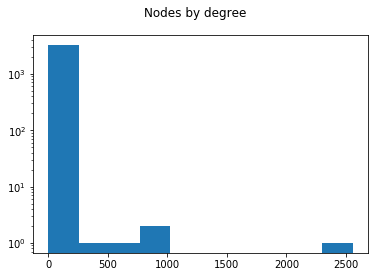

In [99]:
def nodeDegreeHistogram():
    h = nx.degree_histogram(G)
    plt.hist(h)
    plt.yscale('log')
    plt.suptitle("Nodes by degree")
    plt.show()
nodeDegreeHistogram()

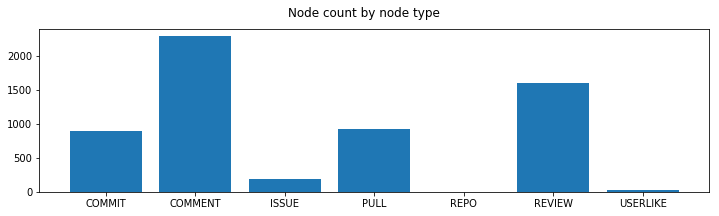

In [112]:
def nodeCountBarChart():
    node_count = Counter()
    for n in G.nodes(data=True):
        node_count[n[1]["type"]] += 1

    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(node_count.keys(), node_count.values())
    fig.suptitle('Node count by node type')
    plt.show()
nodeCountBarChart()

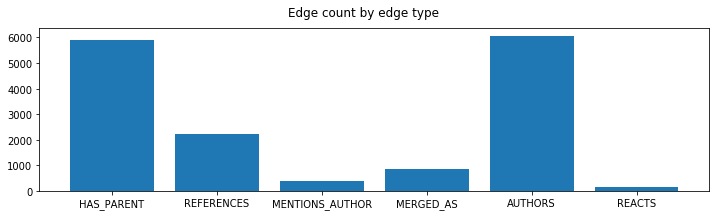

In [113]:
def edgeCountBarChart():
    edge_count = Counter()
    for e in G.edges(data=True):
        edge_count[e[2]["type"]] += 1

    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(edge_count.keys(), edge_count.values())
    fig.suptitle('Edge count by edge type')
    plt.show()
    
edgeCountBarChart()

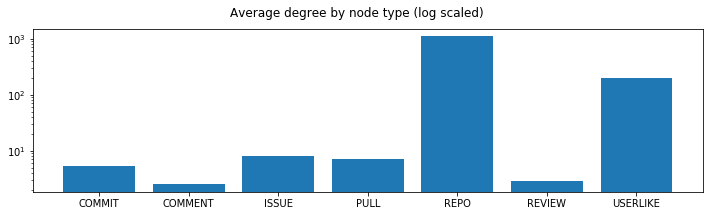

In [120]:
def nodeDegreeByTypeChart():
    type_count = Counter()
    node_type_degree = Counter()
    for n in G.nodes(data=True):
        type = n[1]["type"]
        type_count[type] += 1
        node_type_degree[type] += G.degree(n[0])
    
    average_degree = {}
    for type in type_count.keys():
        average_degree[type] = node_type_degree[type] / type_count[type]
    
    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(average_degree.keys(), average_degree.values())
    ax.set_yscale("log")
    fig.suptitle('Average degree by node type (log scaled)')
    plt.show()
nodeDegreeByTypeChart()

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


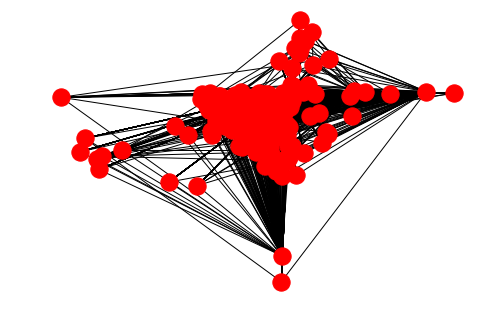

In [23]:
#drawing here is pretty lame without more attention to layout but you solve for you own positions
#this is a hybrid of random and circular because the simple algs were trivially useless
#and the complex algorithms couldn't compute in reasonable time

deg = nx.degree(G)
N = len(G.nodes)
r1 = 1
t1 = 10
r2 = 400
t2 = 20
r3 = 1000

def get_pos(r, n, rv=True):
    if rv:
        rvx = np.random.rand()
        rvy = np.random.rand()
    else:
        rvx = 1
        rvy = 1
    
    return np.array([r*rvx*np.cos(2*np.pi*n/N) , r*rvy*np.sin(2*np.pi*n/N) ])

pos = {}
for n in G.nodes:
    if deg[n]<t1:
        pos[n] = get_pos(r1, n)
    elif deg[n]<t2:
        pos[n] = get_pos(r2, n)
    else :
        pos[n] = get_pos(r3, n)

nx.draw(G, pos)

Nothing particularly interesting until we get the Graph objects "G" correctly labeled with all the meta data so we can use the more fun features of networkX.